## System steup

In [1]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.losses.rmsd import rmsd
from torchmdexp.losses.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch

device = "cuda:0"
precision = torch.float

In [2]:
domain = '7JJK'
ref_pdb = f'/workspace7/torchmd-AD/crystals_dataset/pdb_data/{domain}.pdb'
ref_psf = f'/workspace7/torchmd-AD/crystals_dataset/topology_data/{domain}.psf'

ref_mol = Molecule(ref_pdb)
ref_mol.filter('name CA')
ref_mol.read(ref_psf)

mol = ref_mol

2022-03-08 20:58:56,601 - moleculekit.molecule - WARNING - Alternative atom locations detected. Only altloc A was kept. If you prefer to keep all use the keepaltloc="all" option when reading the file.
2022-03-08 20:58:56,608 - moleculekit.molecule - INFO - Removed 11 atoms. 1199 atoms remaining in the molecule.
2022-03-08 20:58:56,639 - moleculekit.molecule - INFO - Removed 1128 atoms. 71 atoms remaining in the molecule.


In [31]:
native_coords = get_native_coords(ref_mol, device)
native_coords = native_coords.type(precision)
coords = get_native_coords(mol, device)
coords = coords.type(precision)

print('Starting rmsd: ', rmsd(coords, native_coords))

Starting rmsd:  tensor(0.0062, device='cuda:0')


In [14]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters


ff = ForceField.create(mol, '/shared/carles/repo/torchmd-exp/data/ca_priors-dihedrals_general.yaml')
parameters = Parameters(ff, mol, precision=precision, device=device)

In [15]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=350, replicas=1))

In [16]:
get_embeddings(mol, 'cpu', 1)

tensor([[18,  8, 18, 13,  1,  3, 12, 12,  6, 10, 20,  1, 18, 20, 19, 18,  6,  3,
          9,  6,  9, 18,  4, 20, 13,  6, 18, 18, 18, 10, 10, 20, 12, 12,  6, 20,
          2, 20,  9,  6,  1, 10, 21, 19, 21,  7,  3, 10,  9, 19, 18,  1, 19, 21]])

In [17]:
externalmodule = importlib.import_module('torchmdnet.calculators')
nnp = '/shared/carles/repo/torchmd-exp/scripts/trainings/tests/test_cath/cath_128_levels/dih_general_tm_0.6/'
nnp += 'epoch=1233-train_loss=1.0127-val_loss=0.6081.ckpt'
embeddings = torch.tensor([18,  8, 18, 13,  1,  3, 12, 12,  6, 10, 20,  1, 18, 20, 19, 18,  6,  3,
          9,  6,  9, 18,  4, 20, 13,  6, 18, 18, 18, 10, 10, 20, 12, 12,  6, 20,
          2, 20,  9,  6,  1, 10, 21, 19, 21,  7,  3, 10,  9, 19, 18,  1, 19, 21]).repeat(1, 1)
external = externalmodule.External(nnp, embeddings, device)

In [18]:
from torchmd.forces import Forces
external=None
forces = Forces(parameters,terms=['bonds', 'repulsioncg', 'dihedrals'], cutoff=9, rfa=False, switch_dist=None, 
                external=external, exclusions = ('bonds')
               )
# Evaluate current energy and forces. Forces are modified in-place
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=False)
print(Epot)

[77.52456283569336]


## Dynamics

In [19]:
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper

langevin_temperature = 550  # K
langevin_gamma = 1
timestep = 5  # fs

integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)

 13%|█████▎                                    | 637/5000 [03:36<24:46,  2.94it/s]


KeyboardInterrupt: 

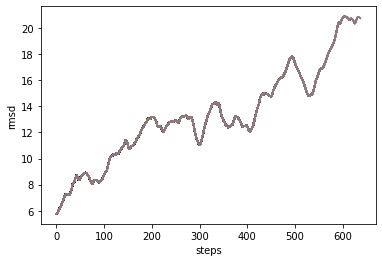

In [20]:
from tqdm import tqdm 
import numpy as np
%matplotlib inline
import time
import pylab as pl
from IPython import display

FS2NS = 1E-6 # Femtosecond to nanosecond conversion

steps = 100000
output_period = 20
save_period = 20
traj = []

trajectoryout = "mytrajectory.npy"

iterator = tqdm(range(1, int(steps / output_period) + 1))
Epot = forces.compute(system.pos, system.box, system.forces)
rmsds = []
Ep = []
tm_scores = []
for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)
    wrapper.wrap(system.pos, system.box)
    currpos = system.pos.detach().cpu().numpy().copy()
    traj.append(currpos)

    rmsds.append(rmsd(system.pos, native_coords).item())
    Ep.append(Epot)
    
    if rmsds[-1] > 40:
        break
    pl.plot(rmsds)
    pl.xlabel('steps')
    pl.ylabel('rmsd')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [26]:
import copy
tmp_mol = copy.deepcopy(mol)
mol_xtc = Molecule(f'/shared/carles/torchmd-exp/data/{name}/{name}_ca_top_dih.psf')
rmsd_proj = MetricRmsd(ref_mol, 'name CA', centerstr='name CA', pbc=False)
rmsd_range = [20,21]
for conf in traj:
    tmp_mol.coords = np.moveaxis(conf, 0, -1)
    tmp_mol.align('name CA', refmol=ref_mol)
    rmsd_value = rmsd_proj.project(tmp_mol)
    if rmsd_range[0] <= rmsd_value.item() <= rmsd_range[1]:
        print(rmsd_value)
        mol_xtc.appendFrames(tmp_mol)
        rmsd_range = [ x + 2.5 for x in rmsd_range]
    

20.00396


In [41]:
mol_xtc.box = np.zeros(shape=(3,mol_xtc.numFrames), dtype=np.float32)
mol_xtc.write(f'/workspace7/torchmd-AD/crystals_dataset/xtc_data/{domain}_kcenters_8clusters.xtc')

# Add folded conformations

In [7]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.losses.rmsd import rmsd
from torchmdexp.losses.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch

device = "cuda:0"
precision = torch.float

In [17]:
prot = 'trp_ca'
name = 'trp'
level = 0
num = 32
mol = Molecule(f'/shared/carles/torchmd-exp/data/{name}/{name}_ca_top_dih.psf')
mol.read(f'/shared/carles/torchmd-exp/data/{name}/{name}_kcenters_{num}clusters_coords.xtc')
ref_mol = Molecule(f'/shared/carles/torchmd-exp/data/{name}/{name}_ca.pdb')

In [19]:
for i in range(mol.coords.shape[2]):
    mol = Molecule(f'/shared/carles/torchmd-exp/data/{name}/{name}_ca_top_dih.psf')
    #mol.read(f'/shared/carles/torchmd-exp/data/{name}/{name}_kcenters_{num}clusters_coords.xtc')
    mol.read(f'/shared/carles/torchmd-exp/data/{name}/{name}_{num}_unfolded_coords.xtc')
    ref_mol = Molecule(f'/shared/carles/torchmd-exp/data/{name}/{name}_ca.pdb') 
    
    mol.coords = np.expand_dims(mol.coords[:, : , i], axis=-1)
    mol.box = np.expand_dims(mol.box[:, 0], axis=-1)


    native_coords = get_native_coords(ref_mol, device)
    native_coords = native_coords.type(precision)
    coords = get_native_coords(mol, device)
    coords = coords.type(precision)


    print('Starting rmsd: ', rmsd(coords, native_coords).item(), f'index {i}')#, 'Starting log_rmsd: ', log_rmsd(coords, native_coords))
    #print('Starting tmscore: ', tm_score(coords, native_coords), 'Starting l2_rmsd: ', l2_rmsd(coords, native_coords))

Starting rmsd:  8.53268814086914 index 0


IndexError: index 1 is out of bounds for axis 2 with size 1

In [120]:
while mol.coords.shape[-1] < 16:
    mol.coords = np.append(mol.coords, ref_mol.coords, axis=-1)
mol.write(f'/workspace7/torchmd-AD/train_curriculum/{name}_contacts/level_{level}/init_states/{prot}.xtc')

In [101]:
# Create level 0
while mol.coords.shape[-1] > 1:
    mol.dropFrames(0)
prot = 'ww_ca'
level = '0'
name = 'ww'
mol.write(f'/workspace7/torchmd-AD/train_energy/{name}_energy/level_{level}/init_states/{prot}.xtc')

In [12]:
mol.coords = np.expand_dims(mol.coords[:, : , 10], axis=-1)
num = 1
mol.write(f'/shared/carles/torchmd-exp/data/{name}/{name}_{num}_unfolded_coords.xtc')

In [20]:
get_embeddings(mol, 'cpu', 1)

tensor([[ 5,  1,  4,  1, 10,  7, 20, 19,  5,  2,  2,  8, 12, 12,  2, 18,  8,  8,
          8, 12]])

In [27]:
mol_xtc.box = np.zeros(shape=(3,mol_xtc.numFrames), dtype=np.float32)
num = 1
mol_xtc.write(f'/shared/carles/torchmd-exp/data/{name}/{name}_{num}_unfolded_coords.xtc')

In [18]:
num = 1